<a href="https://colab.research.google.com/github/Tosinoladejo1/Binary_Classification_Project/blob/main/Word2Vec_Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [70]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random

# Set random seed

In [7]:
# Set environment variables
os.environ['PYTHONHASHSEED'] = str(25)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set seed values
np.random.seed(25)
tf.random.set_seed(25)
random.seed(25)

# TODO: Preprocess

In [8]:
# Preprocess the text
def preprocess(text):
    words=text.split()
    return words


In [11]:
# Replace with the actual path to your file
file_path = '/content/drive/My Drive/small_corpus.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

words = preprocess(text)

print(f"Number of words:{len(words)}")


Number of words:280000


In [10]:
# Import necessary library
import os

# Mount Google Drive (if necessary)
from google.colab import drive
drive.mount('/content/drive')

# Replace with the actual path to your file
file_path = '/content/drive/My Drive/small_corpus.txt'

# Check if the file exists
if os.path.exists(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    words = preprocess(text)

    print(f"Number of words:{len(words)}")
else:
    print(f"File not found: {file_path}")

Mounted at /content/drive
Number of words:280000


# TODO: Build Vocabulary and training data

In [20]:
# TODO: Build vocabulary and generate training data
from collections import defaultdict

def build_and_prepare_data(words, window_size=2):
    # Build vocabulary
    vocab = defaultdict(int)
    for word in words:
        vocab[word] += 1

    word_to_index = {word: i for i, word in enumerate(vocab)}
    index_to_word = {i: word for word, i in word_to_index.items()}

    # Generate context-target pairs
    contexts = []
    targets = []

    for i in range(len(words)):
      target = word_to_index[words[i]]
      context = [
          word_to_index[words[j]]
          for j in range(max(0, i - window_size), min(len(words), i + window_size + 1))
          if i != j
      ]
      for ctx in context:
            contexts.append(context)
            targets.append(target)

    vocab_size = len(vocab)
    num_contexts = len(contexts)
    num_targets = len(targets)

    return vocab, contexts, targets

# TODO: Build CBOW model

In [29]:
# Define CBOW model function
def build_cbow_model(vocab_size, embed_size, window_size):
    input_layer = Input(shape=(2 * window_size), name='context_words')
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_size, name='embedding_layer' )(input_layer)
    average_layer = Lambda(lambda x: tf.reduce_mean(x, axis=1), name='average_layer')(embedding_layer)

    output_layer_name = 'output_layer'
    output_layer = Dense(vocab_size, activation='softmax', name= output_layer_name)(average_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #print the model summary
    model.summary()

    return model

# TODO: Set file path

In [30]:
# TODO: set correct file path
file_path = '/content/drive/My Drive/small_corpus.txt'

# Running the helper functions

In [31]:
# Read the file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

words = preprocess(text)

# Print vocabulary size
print(f"Number of words: {len(words)}")

# Model parameters
window_size = 2

# Prepare dataset
vocab, contexts, targets = build_and_prepare_data(words, window_size)

vocab_size = len(vocab)
# Print vocabulary size
print(f"Vocabulary size: {vocab_size}")

# Print lengths of contexts and targets
print(f"Length of contexts array: {len(contexts)}")
print(f"Length of targets array: {len(targets)}")

Number of words: 280000
Vocabulary size: 28
Length of contexts array: 1119994
Length of targets array: 1119994


# Split the data inton training and validation sets

In [32]:
# Splitting the data
contexts_train, contexts_val, targets_train, targets_val = train_test_split(contexts, targets, test_size=0.2, random_state=25)

embed_size = 2

# Train the model

In [37]:
targets_train = tf.keras.utils.to_categorical(targets_train, num_classes=vocab_size)
targets_val = tf.keras.utils.to_categorical(targets_val, num_classes=vocab_size)

# Create and train the model
model = build_cbow_model(vocab_size, embed_size, window_size)
history = model.fit(contexts_train, targets_train, validation_data=(contexts_val, targets_val), epochs=7, verbose=1)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 context_words (InputLayer)  [(None, 4)]               0         
                                                                 
 embedding_layer (Embedding  (None, 4, 2)              56        
 )                                                               
                                                                 
 average_layer (Lambda)      (None, 2)                 0         
                                                                 
 output_layer (Dense)        (None, 28)                84        
                                                                 
Total params: 140 (560.00 Byte)
Trainable params: 140 (560.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/7
28000/28000 [==============================] - 129s 5ms/step - loss: 2.2415 -

# TODO: Visualise the Training and Validation loss

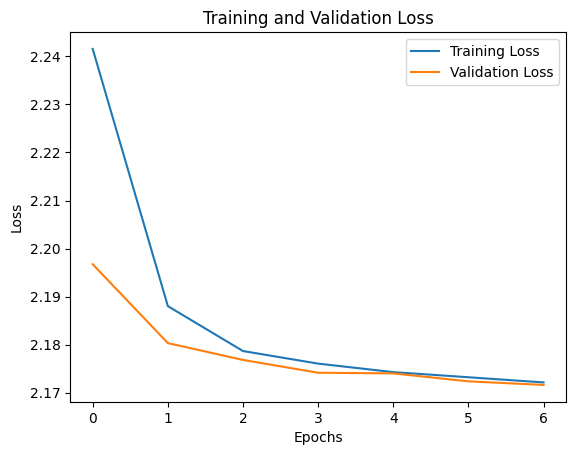

In [41]:
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# TODO: Extract the embeddings

In [42]:
# Extract embeddings
embeddings = model.get_layer('embedding_layer').get_weights()[0]

# TODO: Find similar words

In [61]:
def cosine_similarity(vec_a, vec_b):
    """Calculate the cosine similarity between two vectors."""
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)

    similarity = 0  # Initialize similarity to a default value
    if norm_a != 0 and norm_b != 0:  # Change condition to handle the case when norms are not zero
        similarity = dot_product / (norm_a * norm_b)

    return similarity

def find_similar_words(query_word, vocab, embeddings, top_n=3):
    """Find the top_n words most similar to the query_word based on the embeddings."""
    similarities = []


    query_word_index = vocab[query_word]
    query_embedding = embeddings[query_word_index]
    similarities = []

    for word, index in vocab.items():
      if index < len(embeddings): # Check if index is within bounds
         word_embedding = embeddings[index]
         similarity = cosine_similarity(query_embedding, word_embedding)
         similarities.append((word, similarity))



    # Sort based on similarity scores
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Print top similar words
    print(f"Words most similar to '{query_word}':")
    for word, similarity in similarities[:top_n]:
        print(f"{word}: {similarity:.4f}")



In [62]:
query_words = ['poland', 'thailand', 'morocco']

for query_word in query_words:
    find_similar_words(query_word, vocab, embeddings)
    print("\n")


Words most similar to 'poland':
poland: 1.0000
thailand: 1.0000
morocco: 1.0000


Words most similar to 'thailand':
poland: 1.0000
thailand: 1.0000
morocco: 1.0000


Words most similar to 'morocco':
poland: 1.0000
thailand: 1.0000
morocco: 1.0000




# TODO: Visualise the embeddings

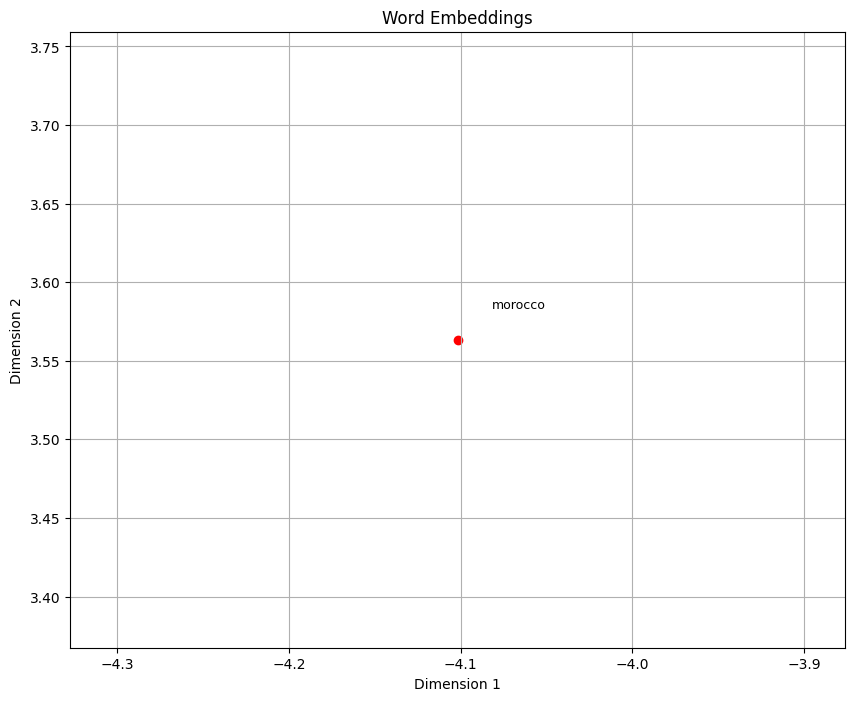

In [64]:
# Create a scatter plot of the embeddings
idx_to_word = {index: word for word, index in vocab.items()}

plt.figure(figsize=(10, 8))
for i, word in idx_to_word.items():
    if i < len(embeddings):  # Check if index is within the bounds of the embeddings array
        emb = embeddings[i]
        plt.scatter(emb[0], emb[1], marker='o', color='red')
        plt.text(emb[0] + 0.02, emb[1] + 0.02, word, fontsize=9)
plt.title('Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()